In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py

import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np

In [2]:
cd ../utils/

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils


In [3]:
import plotting as pplot
import rf_utils as rfutils
import gratings_utils as gutils

In [4]:
import py3utils as p3

In [5]:
%matplotlib notebook

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [7]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

response_type='dff'
traceid = 'traces001'

# fit_thr=0.5
# do_spherical_correction=True

In [8]:
sdata, cells0 = p3.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
             datakey  cell
visual_area               
Li              3754  3754
Lm              4461  4461
V1              4007  4007


In [9]:
# Save counts
statdir = os.path.join(aggregate_dir, 'data-stats','counts')
if not os.path.exists(statdir):
    os.makedirs(statdir)
counts_outfile = os.path.join(statdir, 'all_assigned_cells.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/counts/all_assigned_cells.csv


# Aggregate count functions

In [34]:
def select_assigned_cells(cells0, sdata, experiments=[]):
    '''
    Return assigned cells for a specified experiment.
    cells0: master df of all assigned cells
    sdata: metadata df with all datakeys, experiments, visual areas
    '''
    if not isinstance(experiments, list):
        experiments = [experiments]
    meta_ = sdata[sdata.experiment.isin(experiments)].copy()
    dkeys_ = [(va, dk) for (va, dk), g in meta_.groupby(['visual_area', 'datakey'])]
    cells_ = pd.concat([g for (va, dk), g in \
                            cells0.groupby(['visual_area', 'datakey'])\
                            if (va, dk) in dkeys_])
    return cells_, meta_

def drop_repeats(counts, criterion='max', colname='cell'):
    '''
    From df of counts (N cells per datakey), drop repeats by criterion.
    criterion: takes "max" (or whatever func) along column <colname>
    '''
    counts = p3.split_datakey(counts)
    unique_dsets = p3.select_best_fovs(counts, criterion='max', colname='cell')
    u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
    return u_dkeys
    

In [106]:
def count_n_total(assigned_cells, u_dkeys):
    '''
    Count N cells total per FOV.
    assigned_cells: dataframe of assigned cells for selected experiment.
    u_dkeys:  dataframe of unique datakeys -- used to select and aggregate data.
    '''
    # N cells total per FOV
    n_total0 = pd.concat([g for (va, dk), g \
                          in assigned_cells.groupby(['visual_area', 'datakey'])\
                          if (va, dk) in u_dkeys])
    n_total = n_total0[['visual_area', 'datakey']]\
                .value_counts().reset_index()\
                .rename(columns={0:'total'})
    return n_total

def load_responsive_neuraldata(experiment, traceid='traces001',
                      response_type='dff', trial_epoch='plushalf',
                      responsive_test='nstds', responsive_thr=10,n_stds=2.5,
                      retino_thr=0.01, retino_delay=0.5):
    '''
    Load aggregate data for each FOV, with correctly assigned cells (NDATA).
    Returns all data. Use count_n_responsive() to filter any repeat FOVs.
    '''
    if experiment=='gratings':
        NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
    elif experiment=='blobs':
        NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
    elif experiment=='retino':
        retinodata = load_retinodata(traceid=traceid, 
                                mag_thr=retino_thr, delay_thr=retino_delay)
        NDATA = get_responsive_retino(retinodata, mag_thr=mag_thr)
    elif experiment in ['rfs', 'rfs10']:
        nd_=[]
        for exp in ['rfs', 'rfs10']:
            nd0 = p3.get_aggregate_data(exp, traceid=traceid, 
                              response_type=response_type, epoch=trial_epoch,
                              responsive_test=responsive_test, 
                              responsive_thr=responsive_thr, n_stds=n_stds)
            nd_.append(nd0)
        NDATA = pd.concat(nd_, axis=0).reset_index(drop=True)
    else:
        print("Unknown experiment type: %s" % experiment)
        return None
    return NDATA

def count_n_responsive(NDATA, u_dkeys=None):
    '''
    Given all the data for experiment (NDATA, dataframe), return unique data, 
    i.e., drop repeat FOVs, and count N responsive cells.
    Returns dataframe of N cells for each included dataset.
    
    u_dkeys:  list of unique datakeys -- used to select and aggregate data.
    '''
    # Get UNIQUE datasets (drop repeat FOVs)
    if u_dkeys is None:
        counts = NDATA[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = drop_repeats(counts)
    # Select the unique datasets
    NDATA1 = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
              if (va, dk) in u_dkeys])
    # N cells per FOV that are responsive
    n_responsive = NDATA1[['visual_area', 'datakey','cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()\
                        .rename(columns={'cell': 'responsive'})

    return n_responsive, u_dkeys


# Retino

In [12]:
import importlib
import roi_utils as roiutils
import retino_utils as retutils
importlib.reload(retutils)

import dill as pkl

In [82]:
def get_retino_fft(dk, traceid='traces001', mag_thr=0.01, delay_thr=0.5):
    '''
    Load FFT for dataset, return dataframe of phases & magratios for ALL cells.
    '''
    session, animalid, fovn = p3.split_datakey_str(dk)
    fov='FOV%i_zoom2p0x' % fovn
    try:
        roiid = roiutils.get_roiid_from_traceid(animalid, session, fov, 
                                                traceid=traceid)
    except Exception as e:
        print(e)
        print("[%s] Unable to get retino data (%s)" % (dk, traceid))
    # Select best retino run (if there are multiple)
    all_retinos = pd.DataFrame(retutils.get_average_mag_across_pixels(
                                                animalid, session, fov))
    retinorun = all_retinos.loc[all_retinos[1].idxmax()][0]
    # Load fft results
    fft_results = retutils.load_fft_results(animalid, session, fov, roiid=roiid,
                                            retinorun=retinorun, traceid=traceid, 
                                            create_new=False, use_pixels=False)
    if fft_results is None:
        return None
    fft_soma = fft_results['fft_soma']
    # Create dataframe of magratios -- each column is a condition
    conds=['left', 'right', 'bottom', 'top']
    try:
        magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
        assert all([a in magratios_soma.columns for a in conds]), \
                "Incorrect N conditions (%s)" % str(magratios_soma.columns)
        # Get maps
        df = retutils.get_final_maps(magratios_soma, phases_soma, 
                        trials_by_cond=None, mag_thr=mag_thr, delay_thr=delay_thr)
    except Exception as e:
        print(e)
        return None
    
    return df

def aggregate_retino_data(ret_cells, traceid='traces001', 
                          mag_thr=0.01, delay_thr=0.5, return_missing=False):
    '''
    Loop over all datasets (with assigned cells).
    Returns DF with phase/mag for both az and el (columns). 
    Includes all cells (assigned).
    '''
    retinodata=None
    r_=[]
    errs=[]
    for (va, dk), curr_cells in ret_cells.groupby(['visual_area', 'datakey']):
        df_ = get_retino_fft(dk, mag_thr=mag_thr, delay_thr=delay_thr)        
        if df_ is None:
            errs.append((va, dk))
            continue
        cell_ids = curr_cells['cell'].unique()
        df = df_.loc[cell_ids].copy()
        df['visual_area'] = va
        df['datakey'] = dk
        r_.append(df)
    retinodata = pd.concat(r_, axis=0)
    retinodata = retinodata.reset_index().rename(columns={retinodata.index.name:'cell'})

    if return_missing:
        return retinodata.reset_index, errs
    else:
        return retinodata

In [97]:
def load_retinodata(ret_cells=None, traceid='traces001', mag_thr=0.01, delay_thr=0.5,
                   create_new=False):
    '''
    Load existing aggregate retinodata for all datasets specified
    in dataframe ret_cells, or create new.
    
    Returns df with phase and magnitude for AZ/EL conditions for ALL cells.
    '''
    stats_dir = os.path.join(aggregate_dir, 'data-stats')
    retino_dfile = os.path.join(stats_dir, 'aggr_retinodata_best.pkl')
    if not os.path.exists(retino_dfile):
        create_new=True
    
    if create_new:   
        print("Creating aggregate retinodata and saving")
        assert ret_cells is not None, "Need to provide retino assigned cells."
        retinodata, errs = aggregate_retino_data(ret_cells, traceid=traceid, 
                              mag_thr=mag_thr, delay_thr=delay_thr, return_missing=True)
        
        with open(retino_dfile, 'wb') as f:
            pkl.dump(retinodata, f, protocol=2)
    else:
        with open(retino_dfile, 'rb') as f:
            retinodata = pkl.load(f)
    return retinodata

def get_responsive_retino(retinodata, mag_thr=0.01):
    '''
    retinodata (df): columns are phase and mag for AZ/EL conds (rows=cells).
    Expects aggregate data (cycles by visual area and datakey).
    Returns retino data for cells responsive (mag_thr)
    '''
    # get responsive
    p_ = []
    for (va, dk), rdf in retinodata.dropna().groupby(['visual_area', 'datakey']):
        pass_ = np.where(rdf[['mag_az', 'mag_el']].mean(axis=1)>mag_thr)[0]
        df_ = rdf.iloc[pass_]
        p_.append(df_)
    retino_responsive = pd.concat(p_, axis=0)
    return retino_responsive

## Retino

In [52]:
importlib.reload(retutils)

<module 'retino_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/retino_utils.py'>

In [98]:
# Get retino cells
ret_cells, ret_meta = select_assigned_cells(cells0, sdata, experiments=['retino']) 
mag_thr=0.01
delay_thr=0.5
retinodata = load_retinodata(ret_cells, traceid=traceid, 
                        mag_thr=mag_thr, delay_thr=delay_thr, create_new=create_new)
retino_responsive = get_responsive_retino(retinodata, mag_thr=mag_thr)

In [99]:
retinodata.head()

,cell,phase_az,phase_el,mag_az,mag_el,visual_area,datakey
0,85.0,1.434389,-0.041796,0.008565,0.016800,Li,20190315_JC070_fov1
1,86.0,NaN,NaN,NaN,NaN,Li,20190315_JC070_fov1
2,99.0,NaN,NaN,0.015429,0.006508,Li,20190315_JC070_fov1
3,101.0,1.443087,-0.017280,0.005226,0.009383,Li,20190315_JC070_fov1
4,102.0,NaN,NaN,0.026345,0.017770,Li,20190315_JC070_fov1


In [100]:
# Count
retino_counts = retino_responsive.dropna()\
                    .groupby(['visual_area', 'datakey'])['cell'].count()\
                    .reset_index()
retino_counts.head()

,visual_area,datakey,cell
0,Li,20190315_JC070_fov1,32
1,Li,20190315_JC070_fov2,6
2,Li,20190316_JC070_fov1,26
3,Li,20190319_JC067_fov1,14
4,Li,20190320_JC067_fov1,4


In [40]:

# Get unique
u_dkeys = drop_repeats(retino_counts)
n_responsive = pd.concat([g for (va, dk), g in \
                          retino_counts.groupby(['visual_area', 'datakey'])
                         if (va, dk) in u_dkeys])

[V1] Animalid does not exist: JC078 


In [41]:
n_total = count_n_total(ret_cells, u_dkeys)
n_total.shape, n_responsive.shape

((47, 3), (47, 6))

[V1] Animalid does not exist: JC078 


# Receptive Fields

In [120]:
assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 

In [121]:
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.average_rfs_select(rfdata)

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


In [122]:
counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = drop_repeats(counts)

[V1] Animalid does not exist: JC078 


In [123]:
u_dkeys = drop_repeats(counts)

[V1] Animalid does not exist: JC078 


In [124]:
len(u_dkeys)

32

In [137]:
trial_epoch='plushalf'
responsive_test='nstds'
responsive_thr=7
n_stds=2.5
NDATA = load_responsive_neuraldata('rfs', traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
n_responsive, _ = count_n_responsive(NDATA, u_dkeys)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl


In [138]:
n_responsive.groupby(['visual_area']).sum()

,responsive
visual_area,
Li,517
Lm,1172
V1,1147


In [139]:
rfdata[['visual_area', 'datakey', 'cell']]\
.drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,450,450
Lm,422,422
V1,1090,1090


In [140]:
n_total = count_n_total(assigned_cells, u_dkeys)
n_total.groupby(['visual_area']).sum()

,total
visual_area,
Li,1708
Lm,2267
V1,2583


In [141]:
n_total.groupby(['visual_area'])['datakey'].count()

visual_area
Li    11
Lm    11
V1    10
Name: datakey, dtype: int64

In [142]:
n_responsive.groupby(['visual_area'])['datakey'].count()

visual_area
Li    11
Lm    11
V1    10
Name: datakey, dtype: int64

In [143]:
n_responsive.shape, n_total.shape

((32, 3), (32, 3))

In [136]:
common_ = pd.merge(n_responsive, n_total)

In [53]:
rfdf = pd.concat([g for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

In [54]:
n_fit = rfdf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'fit'})

In [55]:
common = pd.merge(common_, n_fit)


In [56]:
common['fraction_fit'] = common['fit'] / common['responsive']


In [58]:
common.groupby(['visual_area']).describe()

responsive                                                    \
                 count        mean        std   min    25%    50%    75%   
visual_area                                                                
Li                11.0   48.272727  36.072402  11.0  25.00   37.0   63.0   
Lm                 9.0   76.888889  47.395792   7.0  38.00   83.0  113.0   
V1                 8.0  121.625000  55.938582  42.0  88.75  120.5  151.5   

                   total              ...    fit        fraction_fit  \
               max count        mean  ...    75%    max        count   
visual_area                           ...                              
Li           117.0  11.0  162.818182  ...  40.00   75.0         11.0   
Lm           141.0   9.0  215.666667  ...  40.00   59.0          9.0   
V1           219.0   8.0  287.125000  ...  91.75  134.0          8.0   

                                                                         \
                 mean       std       min       25%       50%       75%   
visual_area                                                               
Li           0.488444  0.251267  0.058824  0.333333  0.454545  0.671906   
Lm           0.347108  0.169249  0.070796  0.259740  0.373494  0.428571   
V1           0.511018  0.237170  0.190476  0.363226  0.487736  0.682984   

                       
                  max  
visual_area            
Li           0.810811  
Lm           0.631579  
V1           0.887417  

[3 rows x 32 columns]

In [ ]:
experiment='gratings'

In [21]:
import importlib

In [59]:
importlib.reload(rfutils)

<module 'utils.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/rf_utils.py'>

In [147]:
animalid = 'JC084'
session = '20190525'
fovnum = 1
run='rfs'
dk = '%s_%s_fov%i' % (session, animalid, fovnum)
responsive_cells, ncells_total = p3.get_responsive_cells(animalid, session, fovnum, 
                                        run=run,
                                        responsive_test='nstds', responsive_thr=5,
                                        create_new=False)

list index out of range


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/py3utils.py", line 1432, in get_responsive_cells
    #response_type=response_type,
IndexError: list index out of range


In [145]:
len(responsive_cells), ncells_total

(189, 260)

In [70]:
importlib.reload(rfutils)

<module 'utils.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/rf_utils.py'>

In [186]:
responsive_test='nstds'
responsive_thr=10
n_stds = 2.5

gratings_test='nstds'; gratings_thr=10.0;
blobs_test='nstds'; blobs_thr=10.0;
rfs_test='nstds'; rfs_thr=7.0;
retino_thr=0.01; retino_delay=0.5;

In [188]:
counts_=[]
cellids_=[]
ukeys_=[]
for experiment in ['rfs', 'retino', 'gratings', 'blobs']:
    print("%s -------------------------------------" % experiment)
    if experiment=='gratings':
        assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=[experiment])
        # Drop repeat FOVs by selecting those with most gratings fits
        fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
        #gratings_test='nstds'; gratings_thr=10.0;
        ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                        responsive_test=gratings_test, 
                                        responsive_thr=gratings_thr,
                                        n_bootstrap_iters=n_bootstrap_iters, 
                                        n_resamples=n_resamples)
        gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                        traceid=traceid, fit_desc=ori_fit_desc, 
                                        return_missing=True) 
        print("Missing %i datasets" % len(missing_))
        counts = gdata[gdata['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
                            .drop_duplicates()\
                            .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = drop_repeats(counts)
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid)
        n_responsive, _ = count_n_responsive(NDATA, u_dkeys=u_dkeys)
    elif experiment=='blobs':
        assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                experiments=[experiment])
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                           response_type=response_type,
                                           responsive_test=blobs_test,
                                           responsive_thr=blobs_thr)
        n_responsive, u_dkeys = count_n_responsive(NDATA, u_dkeys=None)
    elif experiment in ['rfs', 'rfs10']:
        assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
        # Drop repeat FOVs by selecting those with most RF fits
        do_spherical_correction=False
        rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                       do_spherical_correction=do_spherical_correction)
        rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, 
                                    fit_desc=rf_fit_desc, reliable_only=False)
        # Combined rfs5/rfs10
        combined_rfs = rfutils.average_rfs_select(rfdata)
        counts = combined_rfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                    .groupby(['visual_area', 'datakey']).count().reset_index()
        u_dkeys = drop_repeats(counts)

        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                                   response_type=response_type,
                                                   responsive_test=rfs_test,
                                                   responsive_thr=rfs_thr)
        n_responsive, _ = count_n_responsive(NDATA, u_dkeys=u_dkeys)
    elif experiment=='retino':
        #retino_thr=0.01; retino_delay=0.5;
        assigned_cells, ret_meta = select_assigned_cells(cells0, 
                                                    sdata, experiments=['retino'])
        NDATA = load_responsive_neuraldata(experiment, traceid=traceid,
                                    retino_thr=retino_thr, retino_delay=retino_delay)
        n_responsive, u_dkeys = count_n_responsive(NDATA, u_dkeys=None)
    # N cells total per FOV
    n_total = count_n_total(assigned_cells, u_dkeys)
    assert n_responsive.shape==n_total.shape, \
        "N responsive (%i) does not match N total (%i)" \
        % (n_responsive.shape[0], n_total.shape[0])
    counts = pd.merge(n_responsive, n_total)
    counts['fraction_responsive'] = counts['responsive']/counts['total'].astype(float)
    counts['stimulus'] = experiment
    counts_.append(counts)
    # Add cell IDs (responsive)
    cellids = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().copy()
    cellids['stimulus'] = experiment
    cellids_.append(cellids)
    
    unique_keys = pd.DataFrame(u_dkeys).rename(\
                                        columns={0:'visual_area', 1: 'datakey'})
    unique_keys['stimulus'] = experiment
    ukeys_.append(unique_keys)


rfs -------------------------------------
N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
[V1] Animalid does not exist: JC078 
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['rfs', 'rfs10']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_plushalf.pkl
retino -------------------------------------
[V1] Animalid does not exist: JC078 
gratings -------------------------------------


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


Missing 1 datasets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
blobs -------------------------------------
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]
[V1] Animalid does not exist: JC078 


In [189]:
COUNTS = pd.concat(counts_, axis=0)
CELLIDS = pd.concat(cellids_, axis=0)
KEYS = pd.concat(ukeys_, axis=0)

In [199]:
any_counts = CELLIDS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'responsive'})
any_counts.groupby(['visual_area']).mean()

,responsive
visual_area,
Li,66.333333
Lm,120.041667
V1,145.210526


In [195]:
incl_=[]
for exp, dkeys in KEYS.groupby(['stimulus']):
    print("%s -------------------------------------" % exp)
    if exp=='rfs':
        assigned_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                                  experiments=['rfs', 'rfs10']) 
    else:
        assigned_cells, ret_meta = select_assigned_cells(cells0, 
                                                    sdata, experiments=[exp])
    incl_cells = pd.concat([g for (va, dk), g in \
                            assigned_cells.groupby(['visual_area', 'datakey'])\
                           if (va, dk) in dkeys[['visual_area', 'datakey']].values])
    incl_cells['stimulus'] = exp
    incl_.append(incl_cells)
all_cells = pd.concat(incl_, axis=0)


blobs -------------------------------------
gratings -------------------------------------
retino -------------------------------------
rfs -------------------------------------


In [200]:
all_counts = all_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'total'})
all_counts.groupby(['visual_area']).mean()

,total
visual_area,
Li,139.037037
Lm,185.875000
V1,210.894737


In [204]:
assert any_counts.shape==all_counts.shape
total_counts = pd.merge(any_counts, all_counts)
total_counts['fraction_responsive'] = total_counts['responsive']/total_counts['total'].astype(float)
total_counts['stimulus'] = 'any'
total_counts.head()

,visual_area,datakey,responsive,total,fraction_responsive,stimulus
0,Li,20190314_JC070_fov1,64,137,0.467153,any
1,Li,20190315_JC070_fov1,107,181,0.591160,any
2,Li,20190315_JC070_fov2,10,102,0.098039,any
3,Li,20190316_JC070_fov1,95,152,0.625000,any
4,Li,20190319_JC067_fov1,34,46,0.739130,any


In [202]:
COUNTS.head()

,visual_area,datakey,responsive,total,fraction_responsive,stimulus
0,Li,20190522_JC089_fov1,11,32,0.343750,rfs
1,Li,20190527_JC092_fov3,65,118,0.550847,rfs
2,Li,20190528_JC092_fov1,37,47,0.787234,rfs
3,Li,20190602_JC091_fov1,103,197,0.522843,rfs
4,Li,20190609_JC099_fov1,61,256,0.238281,rfs


In [205]:
COUNTS.shape, total_counts.shape

((142, 6), (70, 6))

In [208]:
COUNTS = pd.concat([COUNTS, total_counts], axis=0)

In [172]:
# N cells per FOV that pass
# fits_drop = pd.concat([g for (va, dk), g in \
#                         fits_.groupby(['visual_area', 'datakey']) 
#                         if (va, dk) in u_dkeys])
# gratings_pass = fits_drop[['visual_area', 'datakey','cell']]\
#                         .drop_duplicates()\
#                         .groupby(['visual_area', 'datakey']).count().reset_index()\
#                         .rename(columns={'cell': 'good_fit'})

In [67]:
# assert ncells.shape==gratings_pass.shape
# counts = pd.merge(counts_df, gratings_pass)
# counts['fraction_goodfit'] = counts['good_fit']/counts['responsive'].astype(float)
# counts.head()

In [114]:
%matplotlib notebook

<IPython.core.display.Javascript object>


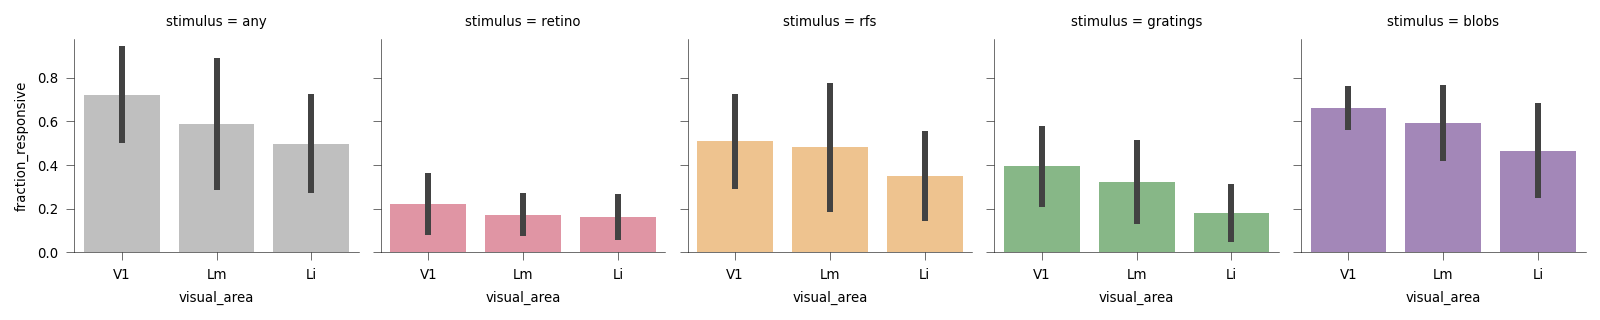

In [209]:
e_colors = {'retino': 'crimson', 'rfs': 'darkorange', 
            'gratings': 'green', 'blobs': 'indigo',
            'any': 'gray'}

g = sns.FacetGrid(col='stimulus', data=COUNTS, height=2,
                  col_order=['any', 'retino', 'rfs', 'gratings', 'blobs'],
                  hue='stimulus', palette=e_colors) #'colorblind')
g.map(sns.barplot, 'visual_area', 'fraction_responsive', 
         order=visual_areas, ci='sd', alpha=0.5)

# Select example cells spanning ALL stimuli

In [106]:
experiment='gratings'

fit_thr=0.5; n_bootstrap_iters=1000; n_resamples=20;
assigned_cells, _ = select_assigned_cells(cells0, sdata, 
                                                      experiments=[experiment])
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                                responsive_test=responsive_test, 
                                n_stds=n_stds, responsive_thr=responsive_thr, 
                                n_bootstrap_iters=n_bootstrap_iters, 
                                n_resamples=n_resamples)
gdata, missing_ = gutils.aggregate_ori_fits(assigned_cells, 
                                traceid=traceid, fit_desc=ori_fit_desc, 
                                return_missing=True) 

In [107]:
gof_thr=0.5
gratings_ = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
gratings_.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,98,98
Lm,293,293
V1,341,341


In [109]:
rf_cells, rf_meta = select_assigned_cells(cells0, sdata, 
                                          experiments=['rfs', 'rfs10']) 
# Drop repeat FOVs by selecting those with most RF fits
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                               do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, rf_cells, 
                            fit_desc=rf_fit_desc, reliable_only=False)
# Combined rfs5/rfs10
rfdata_avg = rfutils.average_rfs_select(rfdata)

# Get RF cells
rfs_ = rfdata_avg[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()
rfs_.groupby(['visual_area']).count()

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4


In [120]:
# Get blobs
trial_epoch='plushalf'
responsive_test='ROC'
responsive_thr=0.05
NDATA = p3.get_aggregate_data('blobs', traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)
objects_ = NDATA[['visual_area', 'datakey', 'cell']].drop_duplicates()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['blobs']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [0.0 -15.0], y: [0.0 -5.0]


In [121]:
f_=[]
for (va, dk), curr_rfs in rfs_.groupby(['visual_area', 'datakey']):
    cells_1 = curr_rfs['cell'].unique()
    # Get grartings cells
    curr_grat = gratings_[(gratings_.visual_area==va) & (gratings_.datakey==dk)].copy()
    cells_2 = curr_grat['cell'].unique()
    # Get cells in both
    common_ = np.intersect1d(cells_1, cells_2)
    
    # Get blobs
    curr_obj = objects_[(objects_.visual_area==va) & (objects_.datakey==dk)].copy()
    cells_3 = curr_obj['cell'].unique()
    common_1 = np.intersect1d(common_, cells_3)
    
    final_cells = curr_rfs[curr_rfs['cell'].isin(common_1)]
    f_.append(final_cells)
ccounts = pd.concat(f_)
ccounts.shape

(188, 3)

In [122]:
ccounts.groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,24,24
Lm,43,43
V1,121,121


In [124]:
ccounts[ccounts['visual_area']=='Li']

,visual_area,datakey,cell
52,Li,20190602_JC091_fov1,16.0
54,Li,20190602_JC091_fov1,23.0
57,Li,20190602_JC091_fov1,26.0
62,Li,20190602_JC091_fov1,34.0
68,Li,20190602_JC091_fov1,42.0
69,Li,20190602_JC091_fov1,43.0
75,Li,20190602_JC091_fov1,51.0
81,Li,20190602_JC091_fov1,64.0
89,Li,20190602_JC091_fov1,74.0
90,Li,20190602_JC091_fov1,76.0


In [125]:
va='Li'
dk='20190602_JC091_fov1'
rid=16

bdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
            & (NDATA['cell']==rid)].copy()

bdata.shape

(1499, 6)

In [145]:
np.reshape(bdata.groupby(['config'])['response'].mean().index.tolist(), (10, 5)).T


array([['config001', 'config006', 'config011', 'config016', 'config021',
        'config026', 'config031', 'config036', 'config041', 'config046'],
       ['config002', 'config007', 'config012', 'config017', 'config022',
        'config027', 'config032', 'config037', 'config042', 'config047'],
       ['config003', 'config008', 'config013', 'config018', 'config023',
        'config028', 'config033', 'config038', 'config043', 'config048'],
       ['config004', 'config009', 'config014', 'config019', 'config024',
        'config029', 'config034', 'config039', 'config044', 'config049'],
       ['config005', 'config010', 'config015', 'config020', 'config025',
        'config030', 'config035', 'config040', 'config045', 'config050']],
      dtype='<U9')

<IPython.core.display.Javascript object>


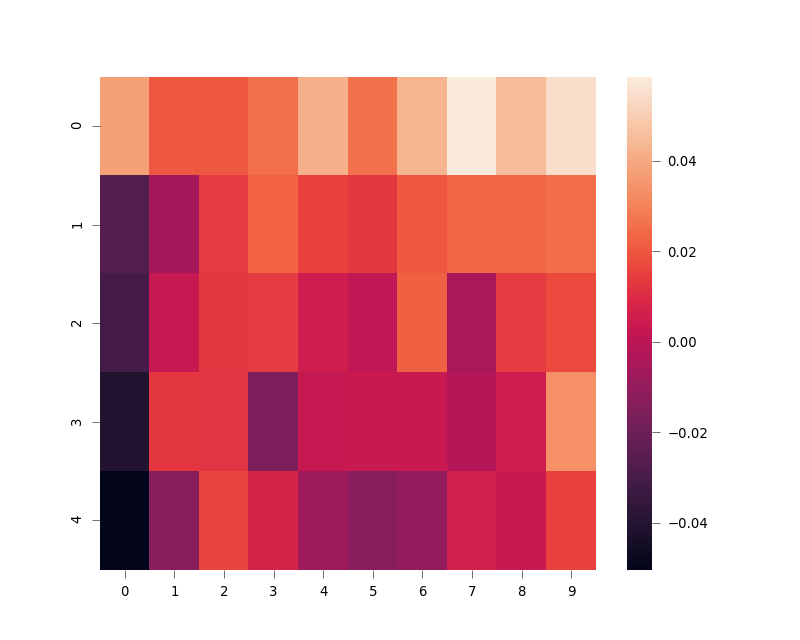

<AxesSubplot:>

In [143]:
obj_map = np.reshape(bdata.groupby(['config'])['response'].mean().values, (10, 5)).T
pl.figure()
sns.heatmap(obj_map)


In [139]:
sdf = p3.get_stimuli(dk, 'blobs')


In [141]:
sdf.loc[bdata.groupby(['config']).mean().index.tolist()]

,xpos,color,object,ypos,morphlevel,stimtype,yrot,size
config001,20.0,0.08,control,-8.0,-1,image,0,30.0
config002,20.0,0.2,control,-8.0,-1,image,0,40.0
config003,20.0,0.32,control,-8.0,-1,image,0,50.0
config004,20.0,0.44,control,-8.0,-1,image,0,10.0
config005,20.0,0.56,control,-8.0,-1,image,0,20.0
config006,20.0,,Blob_N1,-8.0,0,image,0,10.0
config007,20.0,,Blob_N1,-8.0,0,image,0,20.0
config008,20.0,,Blob_N1,-8.0,0,image,0,30.0
config009,20.0,,Blob_N1,-8.0,0,image,0,40.0
config010,20.0,,Blob_N1,-8.0,0,image,0,50.0
